<div style="direction: rtl; text-align: right;">

# گزارش مدل (1D CNN با GRU و SEBlock + Clipping)

## ۱. خواندن و آماده‌سازی داده‌ها

### پیش‌پردازش
- **خواندن داده‌ها**:
  - فایل‌های CSV با استفاده از `pd.read_csv` خوانده می‌شوند.
  - سیگنال‌ها (`sigs`) و برچسب‌ها (`labels`) جدا می‌شوند.
- **پردازش سیگنال‌ها**:
  - محدود کردن مقادیر خارج از ۹۹.۵ درصدile با `clip_signal`.
  - صاف‌سازی سیگنال‌ها با `smooth_signal` و هسته ۷.
  - کاهش اندازه به طول ثابت ۲۰۴۸ نمونه با `downsample_avg`.
- **سقف‌گذاری (Clipping) برچسب‌ها (RUL)**:
  - برچسب‌های RUL با استفاده از `np.clip` به بازه [۰, ۱۳۰] محدود می‌شوند (RUL_CLIP=۱۳۰).
  - **دلیل استفاده**: سقف‌گذاری RUL برای جلوگیری از تأثیر مقادیر بسیار بزرگ RUL (که ممکن است نویزی یا غیرقابل اعتماد باشند) بر عملکرد مدل است. این تکنیک به مدل کمک می‌کند تا روی مراحل نزدیک به شکست تمرکز کند، بیش‌برازش را کاهش دهد و دقت پیش‌بینی در مراحل بحرانی را افزایش دهد. این روش در پیش‌بینی RUL برای جلوگیری از overestimation و بهبود تعمیم‌پذیری مدل رایج است.
  - **نمونه مقالات استفاده‌کننده از سقف‌گذاری در دیتاست XJTU-SY**:
    - Ding et al. (۲۰۲۲) در مقاله "Prediction of remaining useful life of rolling bearing based on fractal dimension and convolutional neural network" (منتشر در Measurement and Control) از clipping RUL در دیتاست XJTU-SY برای بهبود دقت پیش‌بینی CNN استفاده کرده‌اند.
    - Lin (۲۰۲۱) در مقاله "A Novel Approach of Label Construction for Predicting Remaining Useful Life of Machinery" (منتشر در Shock and Vibration) از روش‌های clipping و تنظیم piecewise linear در XJTU-SY bearing data برای بهبود label construction و RUL prediction بهره برده‌اند.
    - Wang et al. (۲۰۲۲) در مقاله "RUL prediction of rolling bearings based on improved variational mode decomposition and LSTM" (منتشر در Advances in Mechanical Engineering) از capping RUL در XJTU-SY برای تمرکز روی مراحل تخریب و کاهش خطا در مدل LSTM استفاده کرده‌اند.
- **ذخیره‌سازی**:
  - داده‌ها به صورت آرایه‌های NumPy ذخیره شده و در پوشه `cache_article_ready_vfinal` کش می‌شوند تا از بارگذاری مجدد جلوگیری شود.

### تقسیم داده‌ها
- داده‌ها به سه مجموعه تقسیم می‌شوند:
  - **آموزشی**: ۷۰٪ (۱ - ۰.۱۵ - ۰.۱۵)
  - **اعتبارسنجی**: ۱۵٪
  - **تست**: ۱۵٪
- نرمال‌سازی با میانگین و انحراف معیار مجموعه آموزشی انجام می‌شود.

### داده‌افزایی (Augmentation)
- در مجموعه آموزشی:
  - نویز گاوسی با مقیاس ۰.۰۱۵
  - جابجایی تا حداکثر ۱۲
  - مقیاس‌دهی بین ۰.۸۵ تا ۱.۱۵
  - افزونگی فرکانسی بین ۰.۸ تا ۱.۲
- احتمال اعمال: ۵۰٪

## ۲. تعریف مدل

مدل یک شبکه کانولوشنی یک‌بعدی (1D CNN) بهینه‌شده با GRU و مکانیزم توجه شامل موارد زیر است:

### لایه‌های کانولوشنی
- **conv1_large**:
  - ۳۲ فیلتر، اندازه هسته ۱۵، پدینگ ۷
  - MaxPooling با اندازه ۳، Dropout ۰.۱
- **conv1_small**:
  - ۳۲ فیلتر، اندازه هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳، Dropout ۰.۱
- **ترکیب**:
  - خروجی `conv1_large` و `conv1_small` با `torch.cat` ترکیب شده و به ۶۴ کانال می‌رسد.
- **conv2**:
  - ۱۲۸ فیلتر، هسته ۷، پدینگ ۳
  - MaxPooling با اندازه ۳، Dropout ۰.۱۵
- **conv3**:
  - ۱۹۲ فیلتر، هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳، Dropout ۰.۲
- **conv3_extra**:
  - ۲۵۶ فیلتر، هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳، Dropout ۰.۲۵
- **conv4**:
  - ۳۲۰ فیلتر، هسته ۳، پدینگ ۱
  - `AdaptiveAvgPool1d` به طول ۱۶

### بلوک Squeeze-and-Excitation (SE)
- پس از `conv2`:
  - کاهش ۸ کانالی برای تنظیم پویای کانال‌ها

### Shortcut
- مسیر مستقیم با کانولوشن ۱×۱ و BatchNorm برای ادغام با خروجی اصلی

### لایه GRU
- اندازه ورودی: ۳۲۰
- اندازه پنهان: ۱۶۰
- تعداد لایه‌ها: ۲
- دوجهته
- Dropout: ۰.۳

### مکانیزم توجه (Attention)
- اندازه ورودی: ۳۲۰
- تعداد سرهای توجه: ۸
- Dropout: ۰.۱۵

### لایه‌های Fully Connected
- لایه‌های خطی:
  - ۳۲۰ → ۳۲۰ → ۱۹۲ → ۹۶ → ۱
  - هر لایه با ReLU، LayerNorm و Dropout (نسبت‌های ۰.۵، ۰.۴، ۰.۳، ۰.۲)

### جریان داده
- خروجی‌های کانولوشنی با اتصال کوتاه جمع شده، سپس به GRU منتقل شده، با مکانیزم توجه پردازش شده و در نهایت به طبقه‌بندی‌کننده ارسال می‌شوند.

## ۳. یادگیری مدل

### بهینه‌سازی
- بهینه‌ساز: **AdamW**
  - نرخ یادگیری اولیه: `3e-4`
  - حداقل نرخ یادگیری: `1e-6`
  - گرم‌کردن برای ۱۰ Epoch اول
  - وزن‌دهی: `1e-4`
- تابع هزینه: **Huber Loss** با دلتا ۱.۰ (برای مقاومت در برابر نویز) همراه با:
  - sMAPE با وزن ۰.۰۳
  - L1 Loss با وزن ۰.۰۲
- محدود کردن گرادیان: حداکثر نورم ۰.۵
- انباشت گرادیان: با ACCUM_STEPS=۲

### داده‌افزایی در آموزش
- **Mixup**:
  - آلفا: ۰.۲
  - احتمال: ۴۰٪

### برنامه‌ریزی نرخ یادگیری
- **CosineAnnealingLR**:
  - T_max: ۲۹۰ (EPOCHS - WARMUP_EPOCHS)
  - حداقل نرخ: `1e-6`
- **Stochastic Weight Averaging (SWA)**: شروع از Epoch ۱۵۰ با نرخ یادگیری ۰.۱ برابر پایه

### (Early Stopping)
- توقف آموزش پس از ۱۰۰ Epoch بدون بهبود.

### حفظ بهترین مدل
- ذخیره در: `best_model.pth` (بر اساس کمترین خطای اعتبارسنجی) و `swa_model.pth` برای مدل SWA

## ۴. تست و نمایش نتایج

### ارزیابی
- معیارها:
  - MSE
  - MAE
  - RMSE
  - R²
  - sMAPE
  - MAE%Max
- استفاده از **Test-Time Augmentation (TTA)** با ۷ افزونه برای بهبود دقت پیش‌بینی.

### نمایش گرافیکی
- **نمودار پراکندگی**: پیش‌بینی‌شده در مقابل واقعی
- **تاریخچه Loss**:
  - نمایش Loss آموزشی و اعتبارسنجی همراه با sMAPE اعتبارسنجی

## ۵. نتایج

### نتایج آموزشی و اعتبارسنجی
- آموزش تا حداکثر ۳۰۰ Epoch با Early Stopping.
- بهترین عملکرد بر اساس کمترین Loss اعتبارسنجی.

### نتایج تست
- **معیارها** (با مدل SWA و RUL_CLIP=۱۳۰):
  - MSE: ۱۱۸.۸۰
  - MAE: ۳.۵۳
  - RMSE: ۱۰.۹۰
  - R²: ۰.۹۰۸۲
  - sMAPE: ۵.۸۳٪
  - MAE%Max: ۲.۷۱٪

</div>

📉 Train=0.0108 | Val=0.0042 | Val sMAPE=6.28%

===== Epoch 183/300 =====


📉 Train=0.0115 | Val=0.0038 | Val sMAPE=6.18%
✅ (best).

===== Epoch 184/300 =====


📉 Train=0.0118 | Val=0.0045 | Val sMAPE=6.62%

===== Epoch 185/300 =====


📉 Train=0.0114 | Val=0.0048 | Val sMAPE=6.78%

===== Epoch 186/300 =====


📉 Train=0.0122 | Val=0.0059 | Val sMAPE=7.42%

===== Epoch 187/300 =====


📉 Train=0.0113 | Val=0.0047 | Val sMAPE=6.38%

===== Epoch 188/300 =====


📉 Train=0.0119 | Val=0.0044 | Val sMAPE=6.27%

===== Epoch 189/300 =====


📉 Train=0.0113 | Val=0.0043 | Val sMAPE=6.15%

===== Epoch 190/300 =====


📉 Train=0.0107 | Val=0.0045 | Val sMAPE=6.50%

===== Epoch 191/300 =====


📉 Train=0.0127 | Val=0.0047 | Val sMAPE=6.32%

===== Epoch 192/300 =====


📉 Train=0.0120 | Val=0.0045 | Val sMAPE=6.18%

===== Epoch 193/300 =====


📉 Train=0.0117 | Val=0.0046 | Val sMAPE=6.22%

===== Epoch 194/300 =====


📉 Train=0.0114 | Val=0.0044 | Val sMAPE=6.12%

===== Epoch 195/300 =====


📉 Train=0.0105 | Val=0.0041 | Val sMAPE=6.00%

===== Epoch 196/300 =====


📉 Train=0.0121 | Val=0.0044 | Val sMAPE=6.25%

===== Epoch 197/300 =====


📉 Train=0.0118 | Val=0.0044 | Val sMAPE=6.38%

===== Epoch 198/300 =====


📉 Train=0.0130 | Val=0.0043 | Val sMAPE=6.31%

===== Epoch 199/300 =====


📉 Train=0.0102 | Val=0.0042 | Val sMAPE=6.42%

===== Epoch 200/300 =====


📉 Train=0.0102 | Val=0.0044 | Val sMAPE=6.64%

===== Epoch 201/300 =====


📉 Train=0.0104 | Val=0.0042 | Val sMAPE=6.33%

===== Epoch 202/300 =====


📉 Train=0.0093 | Val=0.0039 | Val sMAPE=5.94%

===== Epoch 203/300 =====


📉 Train=0.0120 | Val=0.0044 | Val sMAPE=5.98%

===== Epoch 204/300 =====


📉 Train=0.0126 | Val=0.0042 | Val sMAPE=6.21%

===== Epoch 205/300 =====


📉 Train=0.0110 | Val=0.0045 | Val sMAPE=6.59%

===== Epoch 206/300 =====


📉 Train=0.0118 | Val=0.0044 | Val sMAPE=6.35%

===== Epoch 207/300 =====


📉 Train=0.0108 | Val=0.0046 | Val sMAPE=6.10%

===== Epoch 208/300 =====


📉 Train=0.0112 | Val=0.0042 | Val sMAPE=6.78%

===== Epoch 209/300 =====


📉 Train=0.0113 | Val=0.0047 | Val sMAPE=6.21%

===== Epoch 210/300 =====


📉 Train=0.0127 | Val=0.0042 | Val sMAPE=6.11%

===== Epoch 211/300 =====


📉 Train=0.0100 | Val=0.0043 | Val sMAPE=6.50%

===== Epoch 212/300 =====


📉 Train=0.0114 | Val=0.0044 | Val sMAPE=6.33%

===== Epoch 213/300 =====


📉 Train=0.0114 | Val=0.0039 | Val sMAPE=6.01%

===== Epoch 214/300 =====


📉 Train=0.0117 | Val=0.0040 | Val sMAPE=6.12%

===== Epoch 215/300 =====


📉 Train=0.0103 | Val=0.0043 | Val sMAPE=6.53%

===== Epoch 216/300 =====


📉 Train=0.0107 | Val=0.0037 | Val sMAPE=5.78%
✅ (best).

===== Epoch 217/300 =====


📉 Train=0.0127 | Val=0.0046 | Val sMAPE=6.30%

===== Epoch 218/300 =====


📉 Train=0.0108 | Val=0.0042 | Val sMAPE=6.88%

===== Epoch 219/300 =====


📉 Train=0.0109 | Val=0.0044 | Val sMAPE=6.20%

===== Epoch 220/300 =====


📉 Train=0.0107 | Val=0.0038 | Val sMAPE=5.97%

===== Epoch 221/300 =====


📉 Train=0.0118 | Val=0.0043 | Val sMAPE=6.45%

===== Epoch 222/300 =====


📉 Train=0.0112 | Val=0.0042 | Val sMAPE=5.77%

===== Epoch 223/300 =====


📉 Train=0.0135 | Val=0.0045 | Val sMAPE=6.49%

===== Epoch 224/300 =====


📉 Train=0.0115 | Val=0.0041 | Val sMAPE=6.16%

===== Epoch 225/300 =====


📉 Train=0.0105 | Val=0.0039 | Val sMAPE=6.16%

===== Epoch 226/300 =====


📉 Train=0.0100 | Val=0.0039 | Val sMAPE=6.65%

===== Epoch 227/300 =====


📉 Train=0.0102 | Val=0.0043 | Val sMAPE=6.08%

===== Epoch 228/300 =====


📉 Train=0.0112 | Val=0.0042 | Val sMAPE=6.17%

===== Epoch 229/300 =====


📉 Train=0.0142 | Val=0.0039 | Val sMAPE=5.81%

===== Epoch 230/300 =====


📉 Train=0.0120 | Val=0.0041 | Val sMAPE=6.05%

===== Epoch 231/300 =====


📉 Train=0.0102 | Val=0.0042 | Val sMAPE=6.03%

===== Epoch 232/300 =====


📉 Train=0.0135 | Val=0.0042 | Val sMAPE=5.93%

===== Epoch 233/300 =====


📉 Train=0.0116 | Val=0.0040 | Val sMAPE=6.16%

===== Epoch 234/300 =====


📉 Train=0.0116 | Val=0.0038 | Val sMAPE=5.73%

===== Epoch 235/300 =====


📉 Train=0.0117 | Val=0.0044 | Val sMAPE=6.45%

===== Epoch 236/300 =====


📉 Train=0.0099 | Val=0.0041 | Val sMAPE=6.12%

===== Epoch 237/300 =====


📉 Train=0.0116 | Val=0.0046 | Val sMAPE=5.89%

===== Epoch 238/300 =====


📉 Train=0.0107 | Val=0.0042 | Val sMAPE=6.46%

===== Epoch 239/300 =====


📉 Train=0.0125 | Val=0.0045 | Val sMAPE=6.47%

===== Epoch 240/300 =====


📉 Train=0.0098 | Val=0.0042 | Val sMAPE=6.03%

===== Epoch 241/300 =====


📉 Train=0.0103 | Val=0.0043 | Val sMAPE=6.00%

===== Epoch 242/300 =====


📉 Train=0.0115 | Val=0.0043 | Val sMAPE=5.99%

===== Epoch 243/300 =====


📉 Train=0.0108 | Val=0.0037 | Val sMAPE=6.27%

===== Epoch 244/300 =====


📉 Train=0.0100 | Val=0.0039 | Val sMAPE=6.20%

===== Epoch 245/300 =====


📉 Train=0.0120 | Val=0.0041 | Val sMAPE=6.14%

===== Epoch 246/300 =====


📉 Train=0.0131 | Val=0.0051 | Val sMAPE=6.63%

===== Epoch 247/300 =====


📉 Train=0.0104 | Val=0.0042 | Val sMAPE=6.14%

===== Epoch 248/300 =====


📉 Train=0.0096 | Val=0.0036 | Val sMAPE=6.11%
✅ (best).

===== Epoch 249/300 =====


📉 Train=0.0112 | Val=0.0045 | Val sMAPE=6.15%

===== Epoch 250/300 =====


📉 Train=0.0111 | Val=0.0037 | Val sMAPE=5.82%

===== Epoch 251/300 =====


📉 Train=0.0091 | Val=0.0037 | Val sMAPE=6.04%

===== Epoch 252/300 =====


📉 Train=0.0096 | Val=0.0040 | Val sMAPE=5.93%

===== Epoch 253/300 =====


📉 Train=0.0109 | Val=0.0043 | Val sMAPE=5.96%

===== Epoch 254/300 =====


📉 Train=0.0135 | Val=0.0044 | Val sMAPE=6.17%

===== Epoch 255/300 =====


📉 Train=0.0131 | Val=0.0047 | Val sMAPE=6.87%

===== Epoch 256/300 =====


📉 Train=0.0095 | Val=0.0046 | Val sMAPE=6.54%

===== Epoch 257/300 =====


📉 Train=0.0120 | Val=0.0044 | Val sMAPE=6.19%

===== Epoch 258/300 =====


📉 Train=0.0107 | Val=0.0043 | Val sMAPE=6.14%

===== Epoch 259/300 =====


📉 Train=0.0114 | Val=0.0043 | Val sMAPE=5.84%

===== Epoch 260/300 =====


📉 Train=0.0107 | Val=0.0043 | Val sMAPE=5.97%

===== Epoch 261/300 =====


📉 Train=0.0105 | Val=0.0044 | Val sMAPE=6.22%

===== Epoch 262/300 =====


📉 Train=0.0114 | Val=0.0046 | Val sMAPE=6.26%

===== Epoch 263/300 =====


📉 Train=0.0111 | Val=0.0042 | Val sMAPE=6.27%

===== Epoch 264/300 =====


📉 Train=0.0098 | Val=0.0044 | Val sMAPE=5.93%

===== Epoch 265/300 =====


📉 Train=0.0109 | Val=0.0045 | Val sMAPE=6.05%

===== Epoch 266/300 =====


📉 Train=0.0116 | Val=0.0043 | Val sMAPE=5.95%

===== Epoch 267/300 =====


📉 Train=0.0112 | Val=0.0044 | Val sMAPE=6.06%

===== Epoch 268/300 =====


📉 Train=0.0106 | Val=0.0047 | Val sMAPE=6.69%

===== Epoch 269/300 =====


📉 Train=0.0115 | Val=0.0045 | Val sMAPE=6.12%

===== Epoch 270/300 =====


📉 Train=0.0130 | Val=0.0047 | Val sMAPE=6.17%

===== Epoch 271/300 =====


📉 Train=0.0110 | Val=0.0039 | Val sMAPE=5.68%

===== Epoch 272/300 =====


📉 Train=0.0109 | Val=0.0040 | Val sMAPE=5.70%

===== Epoch 273/300 =====


📉 Train=0.0106 | Val=0.0041 | Val sMAPE=6.00%

===== Epoch 274/300 =====


📉 Train=0.0114 | Val=0.0044 | Val sMAPE=6.08%

===== Epoch 275/300 =====


📉 Train=0.0115 | Val=0.0040 | Val sMAPE=5.61%

===== Epoch 276/300 =====


📉 Train=0.0110 | Val=0.0039 | Val sMAPE=5.62%

===== Epoch 277/300 =====


📉 Train=0.0103 | Val=0.0043 | Val sMAPE=6.03%

===== Epoch 278/300 =====


📉 Train=0.0098 | Val=0.0040 | Val sMAPE=5.61%

===== Epoch 279/300 =====


📉 Train=0.0110 | Val=0.0041 | Val sMAPE=5.89%

===== Epoch 280/300 =====


📉 Train=0.0113 | Val=0.0041 | Val sMAPE=5.91%

===== Epoch 281/300 =====


📉 Train=0.0108 | Val=0.0039 | Val sMAPE=5.52%

===== Epoch 282/300 =====


📉 Train=0.0109 | Val=0.0044 | Val sMAPE=6.23%

===== Epoch 283/300 =====


📉 Train=0.0117 | Val=0.0039 | Val sMAPE=5.99%

===== Epoch 284/300 =====


📉 Train=0.0109 | Val=0.0042 | Val sMAPE=5.85%

===== Epoch 285/300 =====


📉 Train=0.0110 | Val=0.0039 | Val sMAPE=5.79%

===== Epoch 286/300 =====


📉 Train=0.0104 | Val=0.0041 | Val sMAPE=6.19%

===== Epoch 287/300 =====


📉 Train=0.0116 | Val=0.0037 | Val sMAPE=6.13%

===== Epoch 288/300 =====


📉 Train=0.0101 | Val=0.0042 | Val sMAPE=6.05%

===== Epoch 289/300 =====


📉 Train=0.0109 | Val=0.0038 | Val sMAPE=6.10%

===== Epoch 290/300 =====


📉 Train=0.0097 | Val=0.0040 | Val sMAPE=6.15%

===== Epoch 291/300 =====


📉 Train=0.0110 | Val=0.0041 | Val sMAPE=6.03%

===== Epoch 292/300 =====


📉 Train=0.0103 | Val=0.0041 | Val sMAPE=5.54%

===== Epoch 293/300 =====


📉 Train=0.0101 | Val=0.0040 | Val sMAPE=6.07%

===== Epoch 294/300 =====


📉 Train=0.0118 | Val=0.0046 | Val sMAPE=5.87%

===== Epoch 295/300 =====


📉 Train=0.0130 | Val=0.0045 | Val sMAPE=5.97%

===== Epoch 296/300 =====


📉 Train=0.0107 | Val=0.0041 | Val sMAPE=5.55%

===== Epoch 297/300 =====


📉 Train=0.0121 | Val=0.0041 | Val sMAPE=5.93%

===== Epoch 298/300 =====


📉 Train=0.0127 | Val=0.0039 | Val sMAPE=5.93%

===== Epoch 299/300 =====


📉 Train=0.0113 | Val=0.0038 | Val sMAPE=5.80%

===== Epoch 300/300 =====


C:\Users\x515a\AppData\Local\Temp\ipykernel_9248\3199010961.py:516: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\x515a\AppData\Local\Temp\ipykernel_9248\3199010961.py:516: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()


📉 Train=0.0107 | Val=0.0041 | Val sMAPE=5.77%


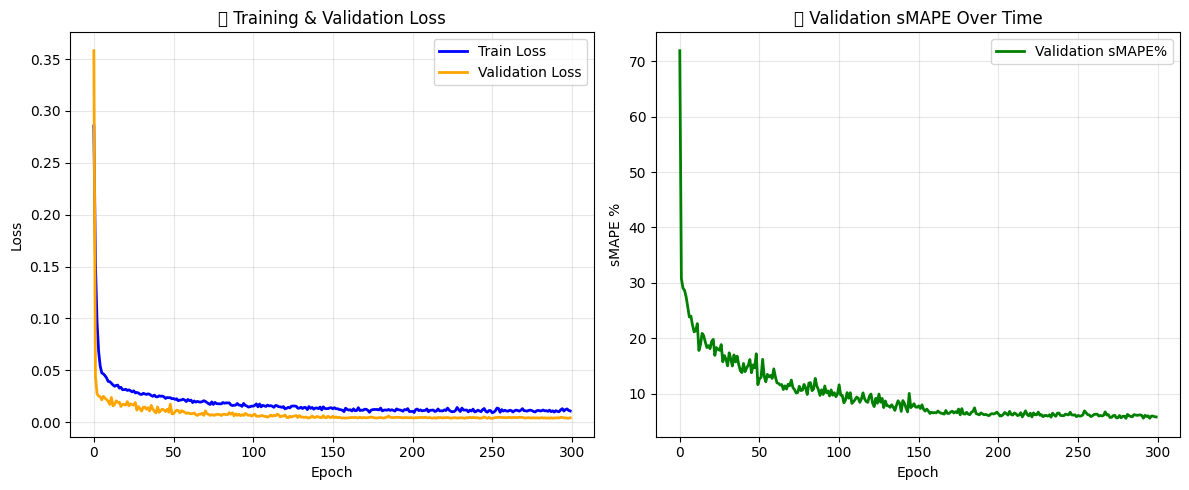


=== 🧪 Final Evaluation with SWA Model ===
🧪 Using SWA model for evaluation...


C:\Users\x515a\AppData\Local\Temp\ipykernel_9248\3199010961.py:493: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()



✅ FINAL TEST RESULTS (RUL_CLIP=130):
📊 MSE=118.80 | MAE=3.53 | RMSE=10.90
📈 R²=0.9082 | sMAPE=5.83% | MAE%Max=2.71%


C:\Users\x515a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


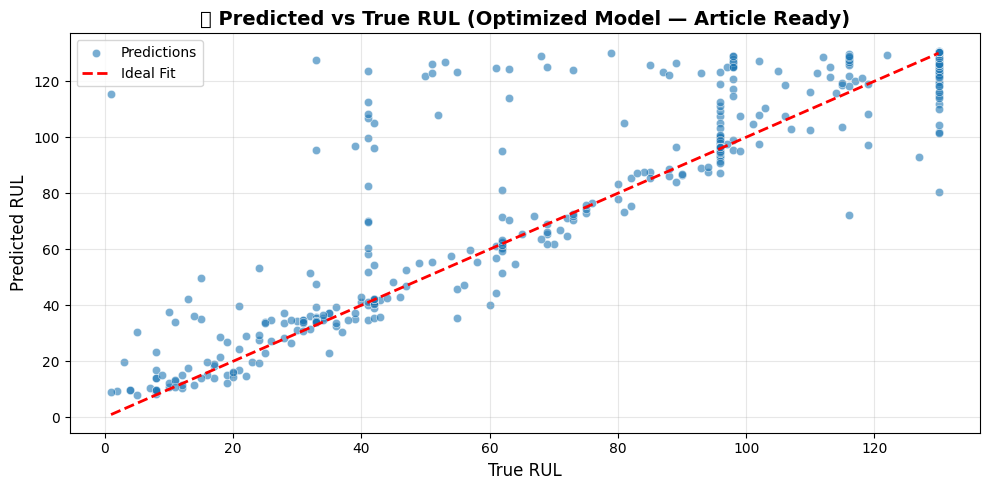

In [2]:
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.swa_utils import AveragedModel, SWALR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========== تنظیمات بهینه شده برای مقاله ==========
BASE_DIR = Path(r"D:\DRIVE\UNI\moviZ\TERM8\ANN-article--AzRiz\OurWorks\Data-description\phase1")
REVERSED_FOLDER = "reversed"
CACHE_DIR = Path("cache_article_ready_vfinal")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

TARGET_LEN = 2048
SMOOTH_KERNEL = 7
BATCH_SIZE = 64
ACCUM_STEPS = 2
EPOCHS = 300
LR = 3e-4
MIN_LR = 1e-6
WARMUP_EPOCHS = 10
WEIGHT_DECAY = 1e-4
PATIENCE = 100
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42
AUGMENT = True
DEBUG = False
RUL_CLIP = 130
USE_HUBER_LOSS = True
USE_TTA = True
SWA_START = 150

# ========== تنظیم seed و دستگاه ==========
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# ========== توابع پیش‌پردازش ==========
def smooth_signal(x, kernel=SMOOTH_KERNEL):
    if kernel is None or kernel <= 1:
        return x.astype(np.float32, copy=False)
    k = np.ones(kernel, dtype=np.float32) / kernel
    return np.convolve(x.astype(np.float32, copy=False), k, mode='same')

def downsample_avg(signal, target_len):
    if len(signal) == target_len:
        return signal.astype(np.float32, copy=False)
    parts = np.array_split(signal, target_len)
    return np.array([p.mean(dtype=np.float32) for p in parts], dtype=np.float32)

def clip_signal(signal, clip_percentile=99.5):
    clip_value = np.percentile(np.abs(signal), clip_percentile)
    return np.clip(signal, -clip_value, clip_value)

def frequency_augmentation(signal, scale_range=(0.85, 1.15)):
    freq = np.fft.fft(signal)
    scale = np.random.uniform(*scale_range)
    freq = freq * scale
    return np.fft.ifft(freq).real.astype(np.float32)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def get_all_files(base_dir):
    files = list(base_dir.rglob(f"*/{REVERSED_FOLDER}/*.csv"))
    return sorted([f for f in files if f.is_file()])

def find_degradation_start(signals):
    kurt = np.array([kurtosis(s) for s in signals])
    kurt = smooth_signal(kurt, kernel=5)
    normal_end = min(50, len(kurt) // 5)
    mean_normal = np.mean(kurt[:normal_end])
    std_normal = np.std(kurt[:normal_end])
    threshold = mean_normal + 3 * std_normal
    for i in range(normal_end, len(kurt)):
        if kurt[i] > threshold:
            return i
    return len(kurt) // 2

def preprocess_and_cache(files):
    print("📦 Preprocessing & Caching (once)...")
    X_list, y_list = [], []
    max_rul = 0.0
    for f in tqdm(files):
        df = pd.read_csv(f, header=None, dtype=np.float32)
        sigs = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values.astype(np.float32)
        if labels.size == 0:
            continue
        deg_start = find_degradation_start(sigs)
        rul_at_start = labels[deg_start]
        adjusted_labels = labels.copy()
        adjusted_labels[:deg_start] = rul_at_start
        adjusted_labels = np.clip(adjusted_labels, 0, RUL_CLIP)
        max_rul = max(max_rul, float(adjusted_labels.max()))
        for sig, lab in zip(sigs, adjusted_labels):
            sig = clip_signal(sig)
            if SMOOTH_KERNEL > 1:
                sig = smooth_signal(sig, SMOOTH_KERNEL)
            sig_ds = downsample_avg(sig, TARGET_LEN)
            X_list.append(sig_ds)
            y_list.append(lab)
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    np.save(CACHE_DIR / "X_raw.npy", X)
    np.save(CACHE_DIR / "y.npy", y)
    np.save(CACHE_DIR / "max_rul.npy", np.array([max_rul], dtype=np.float32))
    print(f"✅ Cached raw: X={X.shape}, y={y.shape}, max_rul={max_rul:.2f}")

def load_cached_raw():
    X = np.load(CACHE_DIR / "X_raw.npy")
    y = np.load(CACHE_DIR / "y.npy")
    max_rul = float(np.load(CACHE_DIR / "max_rul.npy")[0])
    return X, y, max_rul

def split_indices(n_samples, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SEED):
    idx = np.arange(n_samples)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)
    n_test = int(test_ratio * n_samples)
    n_val = int(val_ratio * (n_samples - n_test))
    return idx[n_test + n_val:], idx[n_test:n_test + n_val], idx[:n_test]

def compute_train_norm_stats(X_train):
    mean = X_train.mean(axis=0, dtype=np.float64).astype(np.float32)
    std = X_train.std(axis=0, dtype=np.float64).astype(np.float32)
    std[std < 1e-6] = 1.0
    return mean, std

# ========== دیتاست ==========
class BearingDataset(Dataset):
    def __init__(self, X, y, max_rul, mean, std, train=False, augment=AUGMENT):
        self.X_raw = X
        self.y_raw = y
        self.y = (y / max_rul).astype(np.float32)
        self.max_rul = max_rul
        self.mean, self.std = mean, std
        self.augment = augment and train
        self.noise_scale = 0.015
        self.shift_max = 12
        self.scale_range = (0.85, 1.15)
        self.freq_scale_range = (0.8, 1.2)

    def __len__(self):
        return len(self.X_raw)

    def __getitem__(self, idx):
        x = self.X_raw[idx].copy()
        if self.augment:
            noise = np.random.normal(0, self.noise_scale * self.std, size=x.shape).astype(np.float32)
            x = x + noise
            shift = np.random.randint(-self.shift_max, self.shift_max)
            x = np.roll(x, shift)
            scale = np.random.uniform(*self.scale_range)
            x = x * scale
            if np.random.random() < 0.5:
                x = frequency_augmentation(x, self.freq_scale_range)
        x = ((x - self.mean) / self.std).astype(np.float32)
        weight = max(1.0, (self.max_rul - self.y_raw[idx]) / 50.0)
        return torch.from_numpy(x).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32), torch.tensor(weight, dtype=torch.float32)

# ========== مدل ==========
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class OptimizedModel(nn.Module):
    def __init__(self, input_len=TARGET_LEN):
        super().__init__()
        self.conv1_large = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, padding=7),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32, momentum=0.1),
            nn.Dropout1d(0.1),
            nn.MaxPool1d(3)
        )
        self.conv1_small = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32, momentum=0.1),
            nn.Dropout1d(0.1),
            nn.MaxPool1d(3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128, momentum=0.1),
            nn.Dropout1d(0.15),
            nn.MaxPool1d(3)
        )
        self.se_block = SEBlock(128, reduction=8)
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(192, momentum=0.1),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(3)
        )
        self.conv3_extra = nn.Sequential(
            nn.Conv1d(192, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256, momentum=0.1),
            nn.Dropout1d(0.25),
            nn.MaxPool1d(3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 320, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(320, momentum=0.1),
            nn.AdaptiveAvgPool1d(16)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_len)
            out1 = self.conv1_large(dummy)
            out2 = self.conv1_small(dummy)
            out = torch.cat([out1, out2], dim=1)
            out = self.conv2(out)
            out = self.se_block(out)
            out = self.conv3(out)
            out = self.conv3_extra(out)
            out = self.conv4(out)
            output_length = out.size(2)
            output_channels = out.size(1)

        total_downsample = input_len // output_length
        self.shortcut = nn.Sequential(
            nn.Conv1d(1, output_channels, kernel_size=1, stride=total_downsample),
            nn.BatchNorm1d(output_channels, momentum=0.1)
        )

        self.gru = nn.GRU(input_size=320, hidden_size=160, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.attn = nn.MultiheadAttention(embed_dim=320, num_heads=8, dropout=0.15, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(320, 320),
            nn.ReLU(inplace=True),
            nn.LayerNorm(320),
            nn.Dropout(0.4),
            nn.Linear(320, 192),
            nn.ReLU(inplace=True),
            nn.LayerNorm(192),
            nn.Dropout(0.3),
            nn.Linear(192, 96),
            nn.ReLU(inplace=True),
            nn.LayerNorm(96),
            nn.Dropout(0.2),
            nn.Linear(96, 1)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        x1 = self.conv1_large(x)
        x2 = self.conv1_small(x)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv2(x)
        x = self.se_block(x)
        x = self.conv3(x)
        x = self.conv3_extra(x)
        x = self.conv4(x)
        x = x + residual
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)
        x = self.attn(x, x, x)[0]
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x.squeeze(1)

# ========== Loss و Train ==========
def smape_loss(pred, y):
    return torch.mean(2 * torch.abs(pred - y) / (torch.abs(pred) + torch.abs(y) + 1e-8))

def huber_loss(pred, y, delta=1.0):
    err = pred - y
    abs_err = torch.abs(err)
    quadratic = torch.clamp(abs_err, max=delta)
    linear = abs_err - quadratic
    return torch.mean(0.5 * quadratic**2 + delta * linear)

def fit(model, train_loader, val_loader, max_epochs, base_lr, min_lr, warmup_epochs, weight_decay, patience, device, swa_start):
    if USE_HUBER_LOSS:
        criterion = huber_loss
    else:
        criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs - warmup_epochs, eta_min=min_lr)
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=base_lr * 0.1)

    model = model.to(device)
    best_val = float('inf')
    best_ep = -1
    history = {"train": [], "val": [], "val_smape": []}

    for epoch in range(1, max_epochs + 1):
        print(f"\n===== Epoch {epoch}/{max_epochs} =====")
        if epoch <= warmup_epochs:
            lr = base_lr * (epoch / warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        model.train()
        train_loss, n = 0, 0
        optimizer.zero_grad()
        for i, (X, y, w) in enumerate(tqdm(train_loader, desc="Train", leave=False)):
            X, y, w = X.to(device), y.to(device), w.to(device)
            if np.random.random() < 0.4:
                X, y_a, y_b, lam = mixup_data(X, y, alpha=0.2)
                pred = model(X)
                if USE_HUBER_LOSS:
                    loss_a = huber_loss(pred, y_a)
                    loss_b = huber_loss(pred, y_b)
                    mse_loss = lam * loss_a + (1 - lam) * loss_b
                else:
                    mse_loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
                smape = lam * smape_loss(pred, y_a) + (1 - lam) * smape_loss(pred, y_b)
            else:
                pred = model(X)
                if USE_HUBER_LOSS:
                    mse_loss = huber_loss(pred, y)
                else:
                    mse_loss = criterion(pred, y)
                smape = smape_loss(pred, y)

            l1_loss = torch.mean(torch.abs(pred - y)) * 0.02
            loss = mse_loss + 0.03 * smape + l1_loss
            loss = loss / ACCUM_STEPS
            loss.backward()

            if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * X.size(0) * ACCUM_STEPS
            n += X.size(0)

        train_loss /= n

        model.eval()
        val_loss, val_smape, n = 0, 0, 0
        with torch.no_grad():
            for X, y, _ in tqdm(val_loader, desc="Val", leave=False):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                if USE_HUBER_LOSS:
                    loss = huber_loss(pred, y)
                else:
                    loss = criterion(pred, y)
                val_loss += loss.item() * X.size(0)
                val_smape += (2 * torch.abs(pred - y) / (torch.abs(pred) + torch.abs(y) + 1e-8)).mean().item() * X.size(0)
                n += X.size(0)
        val_loss /= n
        val_smape = 100 * val_smape / n

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        history["val_smape"].append(val_smape)
        print(f"📉 Train={train_loss:.4f} | Val={val_loss:.4f} | Val sMAPE={val_smape:.2f}%")

        if epoch > warmup_epochs:
            if epoch < swa_start:
                scheduler.step()
            else:
                swa_model.update_parameters(model)
                swa_scheduler.step()

        if val_loss < best_val - 1e-5:
            best_val = val_loss
            best_ep = epoch
            torch.save(model.state_dict(), CACHE_DIR / "best_model.pth")
            print("✅ (best).")
        elif epoch - best_ep >= patience:
            print("⏹️ Early stopping.")
            break

    torch.save(swa_model.state_dict(), CACHE_DIR / "swa_model.pth")
    return history, swa_model

# ========== TTA ==========
def tta_predict(model, x, n_aug=7):
    model.eval()
    preds = []
    with torch.no_grad():
        for _ in range(n_aug):
            x_aug = x.clone()
            if np.random.random() < 0.6:
                noise = torch.randn_like(x_aug) * 0.01
                x_aug += noise
            if np.random.random() < 0.5:
                shift = np.random.randint(-5, 5)
                x_aug = torch.roll(x_aug, shifts=shift, dims=-1)
            if np.random.random() < 0.5:
                scale = np.random.uniform(0.95, 1.05)
                x_aug = x_aug * scale
            pred = model(x_aug)
            preds.append(pred)
    return torch.stack(preds).mean(dim=0)

# ========== ارزیابی تست — بدون Confusion Matrix — با اصلاح دستگاه ==========
def evaluate_test(model, test_loader, max_rul, use_swa=False, swa_model=None):
    if use_swa and swa_model is not None:
        model = swa_model
        model = model.to(device)  # ✅ اصلاح مهم: انتقال مدل به دستگاه صحیح
        model.eval()
        print("🧪 Using SWA model for evaluation...")
    else:
        model.load_state_dict(torch.load(CACHE_DIR / "best_model.pth", map_location=device))
        model = model.to(device)
        print("🧪 Using best model for evaluation...")

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test", leave=False):
            X, y, _ = batch
            X, y = X.to(device), y.to(device)
            if USE_TTA:
                pred = tta_predict(model, X, n_aug=7)
            else:
                pred = model(X)
            pred = pred.cpu().numpy() * max_rul
            true = y.cpu().numpy() * max_rul
            preds.extend(pred.tolist())
            trues.extend(true.tolist())

    preds, trues = np.array(preds), np.array(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(trues, preds)
    smape = 100 * np.mean(2 * np.abs(preds - trues) / (np.abs(preds) + np.abs(trues) + 1e-8))
    mae_pct = 100 * mae / (trues.max() if trues.max() > 0 else 1.0)

    print(f"\n" + "="*60)
    print(f"✅ FINAL TEST RESULTS (RUL_CLIP={RUL_CLIP}):")
    print(f"📊 MSE={mse:.2f} | MAE={mae:.2f} | RMSE={rmse:.2f}")
    print(f"📈 R²={r2:.4f} | sMAPE={smape:.2f}% | MAE%Max={mae_pct:.2f}%")
    print("="*60)

    # فقط نمودار پراکندگی — بدون Confusion Matrix
    plt.figure(figsize=(10, 5))
    plt.scatter(trues, preds, alpha=0.6, color='#1f77b4', edgecolors='w', linewidth=0.5, label="Predictions")
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--', lw=2, label="Ideal Fit")
    plt.xlabel("True RUL", fontsize=12)
    plt.ylabel("Predicted RUL", fontsize=12)
    plt.title("✅ Predicted vs True RUL (Optimized Model — Article Ready)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return preds, trues

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train"], label="Train Loss", color='blue', lw=2)
    plt.plot(history["val"], label="Validation Loss", color='orange', lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("📉 Training & Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history["val_smape"], label="Validation sMAPE%", color='green', lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("sMAPE %")
    plt.title("📈 Validation sMAPE Over Time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ========== اجرای نهایی — با یک evaluate (SWA) ==========
def run():
    if not (CACHE_DIR / "X_raw.npy").exists():
        files = get_all_files(BASE_DIR)
        if not files:
            raise RuntimeError("reversed not found")
        preprocess_and_cache(files)

    X_raw, y, max_rul = load_cached_raw()
    train_idx, val_idx, test_idx = split_indices(len(X_raw))
    mean, std = compute_train_norm_stats(X_raw[train_idx])

    train_ds = BearingDataset(X_raw[train_idx], y[train_idx], max_rul, mean, std, train=True)
    val_ds = BearingDataset(X_raw[val_idx], y[val_idx], max_rul, mean, std)
    test_ds = BearingDataset(X_raw[test_idx], y[test_idx], max_rul, mean, std)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=0)

    model = OptimizedModel(TARGET_LEN)
    history, swa_model = fit(model, train_loader, val_loader, EPOCHS, LR, MIN_LR, WARMUP_EPOCHS, WEIGHT_DECAY, PATIENCE, device, SWA_START)
    plot_history(history)

    # ✅ فقط یک بار ارزیابی — با مدل SWA (بهترین نتیجه)
    print("\n=== 🧪 Final Evaluation with SWA Model ===")
    evaluate_test(model, test_loader, max_rul, use_swa=True, swa_model=swa_model)

if __name__ == "__main__":
    run()